In [1]:
# Standard Library Imports
import os
import sys
from typing import List, Any, Callable, Union, Tuple, Optional
from importlib import reload

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from pprint import pprint
from functools import partial
from glob import glob
import cftime
import json
import string

# Custom Module Imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
import constants
sys.path.append(constants.MODULE_DIR)
import open_ds
import open_zecmip
import utils
import signal_to_noise as sn
import plotting_functions
import xarray_extender as xe
import zec_calculation_functions
import drift_functions
import sn_plotting
import stats

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# # Logging
# logger = utils.get_notebook_logger()

Matplotlib created a temporary config/cache directory at /jobfs/114506127.gadi-pbs/matplotlib-90k7ddec because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [2]:
import listXarray as lxr
reload(lxr)
from listXarray import listXarray

In [3]:
# client.close()

In [4]:
from dask.distributed import Client
client = Client()
client

- State start
-   Scheduler at:     tcp://127.0.0.1:32895
-   dashboard at:         /proxy/8787/status
- Registering Worker plugin shuffle
-         Start Nanny at: 'tcp://127.0.0.1:46873'
-         Start Nanny at: 'tcp://127.0.0.1:46553'
-         Start Nanny at: 'tcp://127.0.0.1:40557'
-         Start Nanny at: 'tcp://127.0.0.1:46293'
-         Start Nanny at: 'tcp://127.0.0.1:34371'
-         Start Nanny at: 'tcp://127.0.0.1:44991'
-         Start Nanny at: 'tcp://127.0.0.1:43871'
- Register worker <WorkerState 'tcp://127.0.0.1:35619', name: 2, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:35619
- Starting established connection to tcp://127.0.0.1:33932
- Register worker <WorkerState 'tcp://127.0.0.1:33365', name: 6, status: init, memory: 0, processing: 0>
- Starting worker compute stream, tcp://127.0.0.1:33365
- Starting established connection to tcp://127.0.0.1:33958
- Register worker <WorkerState 'tcp://127.0.0.1:39149', name: 1, status

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32895,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:34411,Total threads: 4
Dashboard: /proxy/44915/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:46873,


# Opening Data

In [5]:
chunks = {'lat':-1, 'lon':-1, 'time':-1, 'ensemble':-1}

In [6]:
a1_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1000pgc', 'tas', chunks=chunks, logginglevel='ERROR'
                                                          ).to_dataarray('tas').sort_by_refkey()

0.3.0


In [7]:
pct_raw_xrlist = open_zecmip.extract_experiment_into_xrlist('1pct', 'tas', chunks=chunks).to_dataarray('tas').sort_by_refkey()

In [8]:
esmpi_raw_xrlist = (open_zecmip.extract_experiment_into_xrlist('picontrol', 'tas', chunks=chunks, logginglevel='INFO')
                    .to_dataarray('tas')
                    .isel(ensemble=0)
                    .squeeze('ensemble')
                    .sort_by_refkey()
                    .rename({'latitude':'lat', 'longitude': 'lon'}))

- ACCESS-ESM1-5
-      r1i1p1f1 - /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc
- CanESM5
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p1f1/Amon/tas/gn/v20190429/*.nc
-      r1i1p2f1 - /g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc
- MIROC-ES2L
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc
- UKESM1-0-LL
-      r1i1p1f2 - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20200828/*.nc
- MPI-ESM1-2-LR
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc
-      r2i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r2i1p1f1/Amon/tas/gn/v20190815/*.nc
- GISS-E2-1-G-CC
-      r1i1p1f1 - /g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v2

In [9]:
# Match all the ensemble dimensions
pct_raw_xrlist = pct_raw_xrlist.cross_match_dim(a1_raw_xrlist, 'ensemble')
a1_raw_xrlist = a1_raw_xrlist.cross_match_dim(pct_raw_xrlist, 'ensemble')

In [10]:
# Only selecting one ensemble member for each model
a1_raw_xrlist = a1_raw_xrlist.isel(ensemble=0).chunk('auto')
pct_raw_xrlist = pct_raw_xrlist.isel(ensemble=0).chunk('auto')
esmpi_raw_xrlist = esmpi_raw_xrlist.isel(ensemble=0).chunk('auto')

In [11]:
# After the year 1000 all values appear to be 0
#esmpi_raw_xrlist['CanESM5'] = esmpi_raw_xrlist['CanESM5'].isel(time=slice(None,1000))

In [12]:
esmpi_raw_xrlist['CanESM5']

<xarray.DataArray 'tas' (model: 1, time: 16800, lat: 64, lon: 128)>
dask.array<getitem, shape=(1, 16800, 64, 128), dtype=float32, chunksize=(1, 2400, 64, 128), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 5201-01-16 12:00:00 ... 6600-12-16 12:00:00
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * model     (model) <U7 'CanESM5'
    ensemble  <U8 'r1i1p1f1'
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        ST+273.16, CMIP_table_comment: near-surface (usually, 2 m...
    units:          K
    original_name:  ST
    history:        degctok 2019-04-30T17:18:16Z altered by CMOR: Treated sca...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

# Global Mean Calculation

In [13]:
# Convert to celcius
a1_raw_xrlist = a1_raw_xrlist - 273.15
pct_raw_xrlist = pct_raw_xrlist - 273.15
esmpi_raw_xrlist = esmpi_raw_xrlist - 273.15

In [14]:
esmpi_regrid_xrlist = esmpi_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
pct_regrid_xrlist = pct_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')
a1_regrid_xrlist = a1_raw_xrlist.chunk('auto').regrid('MPI-ESM1-2-LR', 'bilinear').set_refkeys('model')

In [15]:
# Making the data yearly
esmpi_xrlist = esmpi_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
pct_xrlist = pct_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')
a1_xrlist = a1_regrid_xrlist.resample(time='Y').mean(dim='time').set_refkeys('model').chunk('auto')

In [16]:
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 185, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5 ({'model': 1, 'time': 101, 'lat': 96, 'lon': 192})
CESM2         ({'model': 1, 'time': 150, 'lat': 96, 'lon': 192})
CanESM5       ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4     ({'model': 1, 'time': 200, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC({'model': 1, 'time': 180, 'lat': 96, 'lon': 192})
MIROC-ES2L    ({'model': 1, 'time': 248, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL   ({'model': 1, 'time': 330, 'lat': 96, 'lon': 192})

In [17]:
# Subsetting to only first 150 years so all models have equal footing

# Reduce time so that the smalles time densions matches. This is at 101 years
a1_xrlist = a1_xrlist.isel(time=slice(None, 100))
a1_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
ACCESS-ESM1-5 ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CESM2         ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
CanESM5       ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GFDL-ESM4     ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
GISS-E2-1-G-CC({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
MIROC-ES2L    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
NorESM2-LM    ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})
UKESM1-0-LL   ({'model': 1, 'time': 100, 'lat': 96, 'lon': 192})

In [18]:
# The global weighted mean
pct_smean_xrlist = pct_xrlist.chunk('auto').apply(sn.calculate_global_value, 'tas')
a1_smean_xrlist = a1_xrlist.chunk('auto').apply(sn.calculate_global_value, 'tas')
esmpi_smean_xrlist = esmpi_xrlist.apply(sn.calculate_global_value, 'tas')

In [19]:
esmpi_smean_xrlist = esmpi_smean_xrlist.compute()
a1_smean_xrlist = a1_smean_xrlist.compute()
pct_smean_xrlist = pct_smean_xrlist.compute()

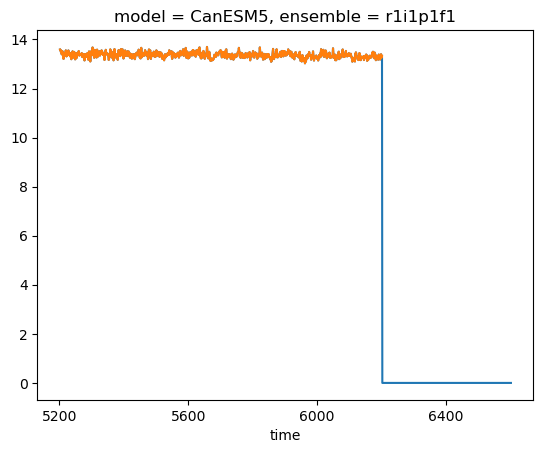

In [20]:
esmpi_smean_xrlist['CanESM5'].plot()
esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000)).plot()

In [21]:
esmpi_smean_xrlist['CanESM5'] = esmpi_smean_xrlist['CanESM5'].isel(time=slice(None, 1000))

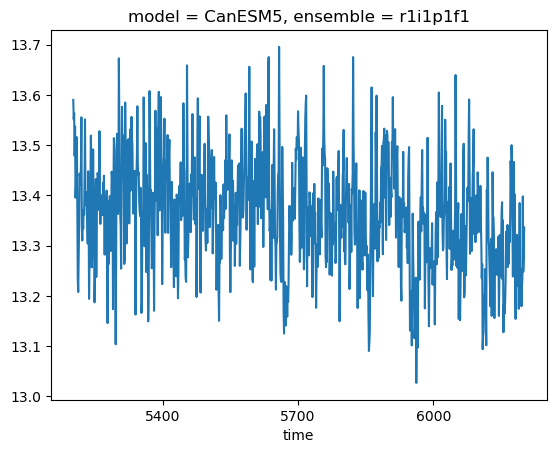

In [22]:
esmpi_smean_xrlist['CanESM5'].plot()

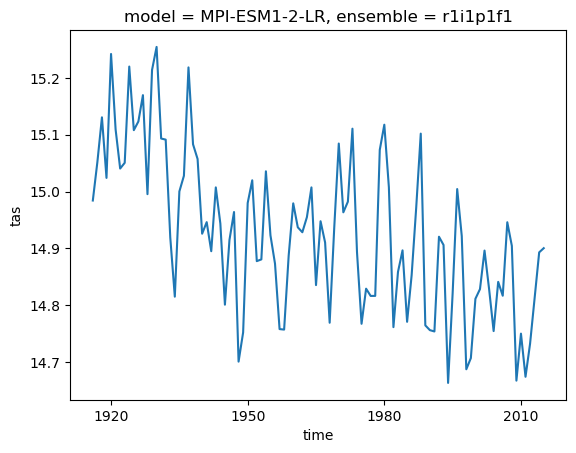

In [23]:
a1_smean_xrlist[0].plot()

In [24]:
# Calculate the values at the branching point
branch_point_mean_xrlist = listXarray([zec_calculation_functions.calculate_branch_average(
    pct_smean_xrlist[model], a1_smean_xrlist[model], logginglevel='INFO') for model in pct_smean_xrlist.refkeys]).set_refkeys('model')

- ['MPI-ESM1-2-LR'] - ['MPI-ESM1-2-LR']
- branch_start_time=cftime.DatetimeProlepticGregorian(1915, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=65
- 

- ['ACCESS-ESM1-5'] - ['ACCESS-ESM1-5']
- branch_start_time=cftime.DatetimeProlepticGregorian(168, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CESM2'] - ['CESM2']
- branch_start_time=cftime.DatetimeNoLeap(68, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=67
- 

- ['CanESM5'] - ['CanESM5']
- branch_start_time=cftime.DatetimeNoLeap(1911, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=61
- 

- ['GFDL-ESM4'] - ['GFDL-ESM4']
- branch_start_time=cftime.DatetimeNoLeap(64, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=63
- 

- ['GISS-E2-1-G-CC'] - ['GISS-E2-1-G-CC']
- branch_start_time=cftime.DatetimeNoLeap(1920, 12, 31, 0, 0, 0, 0, has_year_zero=True)
- onepct_branch_arg=70
- 

- ['MIROC-ES2L'] - ['MIROC-ES2L']
- branch_start_time=cftime.DatetimeGregorian(1913, 

In [25]:
# The amomaly time series from the branch point
a1_smean_anom_xrlist = (a1_smean_xrlist - branch_point_mean_xrlist).compute()

In [26]:
a1_smean_xrlist

key_dim = model


Number of da/ds: 9
---------------
MPI-ESM1-2-LR ({'model': 1, 'time': 100})
ACCESS-ESM1-5 ({'model': 1, 'time': 100})
CESM2         ({'model': 1, 'time': 100})
CanESM5       ({'model': 1, 'time': 100})
GFDL-ESM4     ({'model': 1, 'time': 100})
GISS-E2-1-G-CC({'model': 1, 'time': 100})
MIROC-ES2L    ({'model': 1, 'time': 100})
NorESM2-LM    ({'model': 1, 'time': 100})
UKESM1-0-LL   ({'model': 1, 'time': 100})

In [27]:
# All modles now have matching coordinates - can now be converted to xarray
# previosly a1 was a1_smean_anom_xrlist
a1_smean_anom_ds = a1_smean_anom_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
a1_smean_ds = a1_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
pct_smean_ds = pct_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')
esmpi_smean_ds = esmpi_smean_xrlist.copy(deep=True).apply(utils.reset_time_to_0_start).concat('model')

In [28]:
# This way procudes the same as when you average first then take the anomalies. However, we also get the anomaleis
# time series which is useful
zec25_ds = a1_smean_anom_ds.isel(time=slice(15, 35)).mean(dim='time')
zec50_ds = a1_smean_anom_ds.isel(time=slice(40, 60)).mean(dim='time')
zec50_ds

<xarray.DataArray 'tas' (model: 9)>
array([-0.27015668,  0.01130198, -0.3096341 , -0.10102565, -0.20398543,
       -0.08966743, -0.1082242 , -0.33274778,  0.28783543])
Coordinates:
  * model     (model) <U14 'MPI-ESM1-2-LR' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
    ensemble  <U8 'r1i1p1f1'

In [29]:
zec50_ds.to_pandas().sort_index().round(2)

model
ACCESS-ESM1-5     0.01
CESM2            -0.31
CanESM5          -0.10
GFDL-ESM4        -0.20
GISS-E2-1-G-CC   -0.09
MIROC-ES2L       -0.11
MPI-ESM1-2-LR    -0.27
NorESM2-LM       -0.33
UKESM1-0-LL       0.29
dtype: float64

In [30]:
a1_smean_anom_ds = a1_smean_anom_ds.dropna(dim='time')

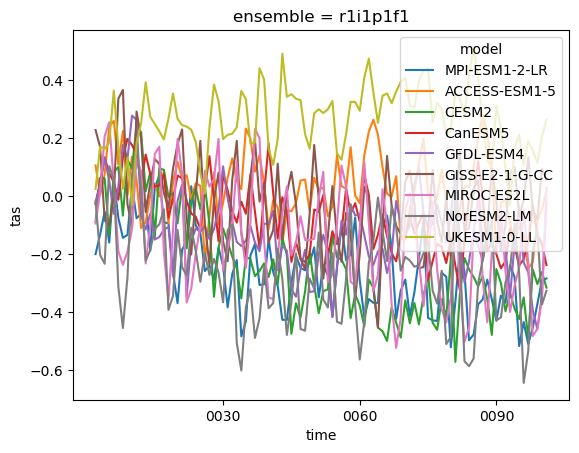

In [31]:
a1_smean_anom_ds.plot(hue='model');

# SN Calculation

In [32]:
# Detrend the data
a1_smean_anom_trendfit_ds = stats.trend_fit(a1_smean_anom_ds, method='polynomial', order=4)
a1_smean_anom_detrend_ds = a1_smean_anom_ds - a1_smean_anom_trendfit_ds

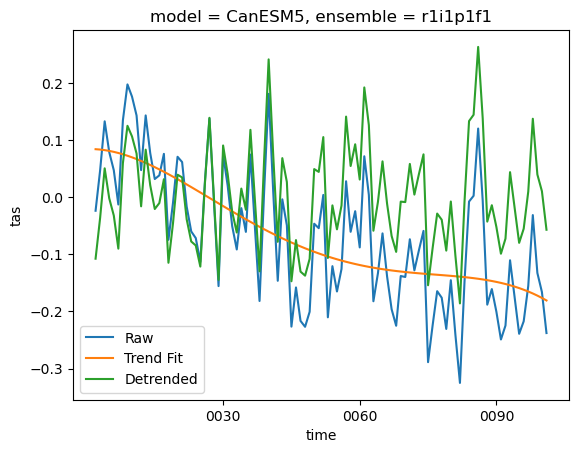

In [33]:
model = 'CanESM5'#'CESM2'
a1_smean_anom_ds.sel(model=model).plot(label='Raw')
a1_smean_anom_trendfit_ds.sel(model=model).plot(label='Trend Fit')
a1_smean_anom_detrend_ds.sel(model=model).plot(label='Detrended')
plt.legend()

In [34]:
%%time
# Calculate thje rolling and non rolling signal to noise

# Params to use for both
SN_PARAMS = dict(return_all=True, center=True, return_control=True, logginglevel='ERROR')

# Static
sn_multi_static_ds, sn_multi_static_control_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=False, lower_bound=5, upper_bound=95,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Rolling
sn_multi_rolling_ds, sn_multi_rolling_control_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    a1_smean_anom_ds, esmpi_smean_ds, da_for_noise = a1_smean_anom_detrend_ds,
    rolling_noise=True, lower_bound=5, upper_bound=95,  **SN_PARAMS, **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)

# Set refkeys and compute
sn_multi_static_ds = sn_multi_static_ds.compute()
sn_multi_rolling_ds = sn_multi_rolling_ds.compute()


Experiment
--------

Concatenating objects - PLEASE be patient!
 - Finished

Control
------


Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge

Experiment
--------
10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge
CPU times: user 6.1 s, sys: 339 ms, total: 6.44 s
Wall time: 6.03 s


In [35]:
test_window = 40
method='periods'

In [36]:
test_dict = dict(window=test_window, method=method)

In [37]:
signal_a1_ds = a1_smean_anom_ds.sel(model='UKESM1-0-LL').sn.rolling_signal(**test_dict).squeeze()
noise_a1_ds = a1_smean_anom_ds.sel(model='UKESM1-0-LL').sn.calculate_rolling_noise(window=test_window).squeeze()

In [38]:
signal_ds = esmpi_smean_ds.sel(model='UKESM1-0-LL').sn.rolling_signal(**test_dict).squeeze()
noise_test = esmpi_smean_ds.sel(model='UKESM1-0-LL').sn.calculate_rolling_noise(window=test_window).squeeze()

(array([ 1.33831322,  5.35325287,  4.01493965,  1.33831322,  1.33831322,
         2.67662643,  4.01493965, 12.04481895, 12.04481895, 10.70650573]),
 array([-0.06560698, -0.04738237, -0.02915775, -0.01093313,  0.00729148,
         0.0255161 ,  0.04374071,  0.06196533,  0.08018994,  0.09841456,
         0.11663918]),
 <BarContainer object of 10 artists>)

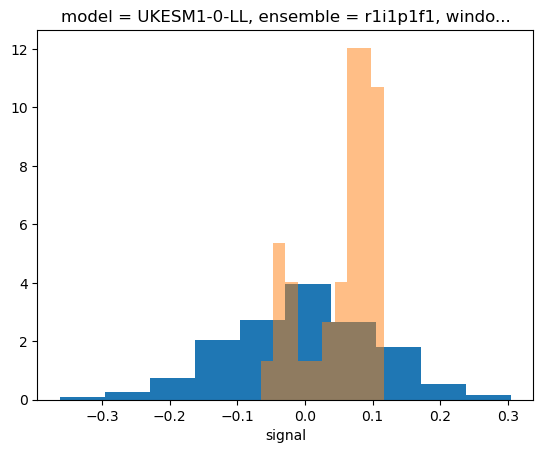

In [39]:
signal_ds.plot.hist(density=True)
signal_a1_ds.plot.hist(density=True, alpha=0.5)

In [40]:
array = sn_multi_rolling_control_ds.sel(model='UKESM1-0-LL', window=40).signal_to_noise.values

In [41]:
list(map(lambda q: np.nanpercentile(array, q=q), [5, 95]))

[-2.0288261953706384, 2.1305240787556285]

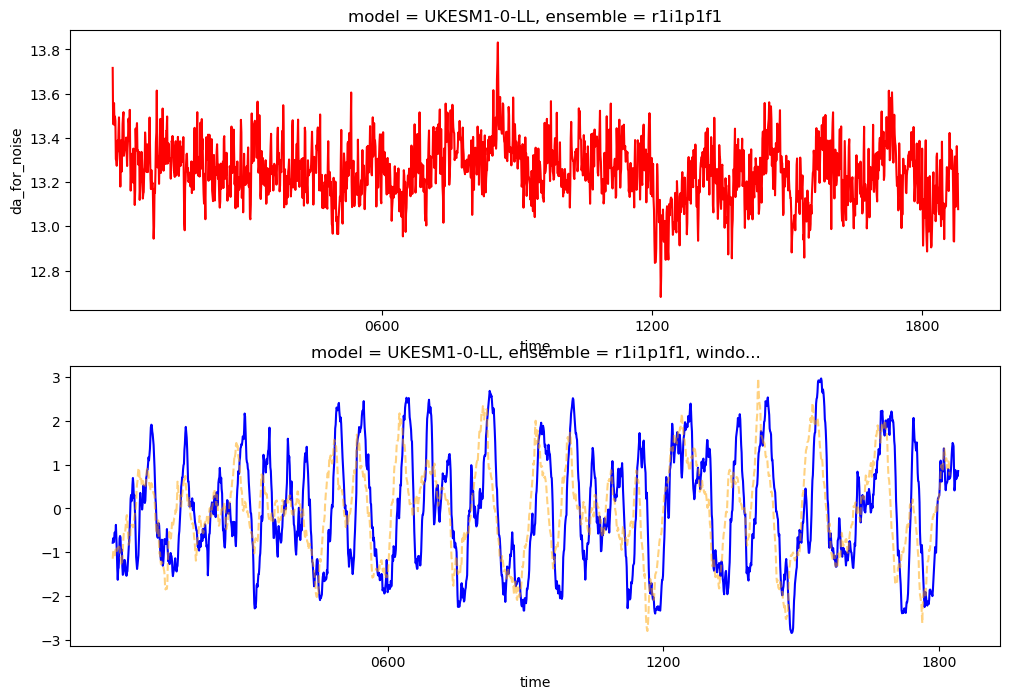

In [42]:
fig, (ax, ax2) = plt.subplots(2, 1,figsize=(12, 8))
# ax2 = ax.twinx()
esmpi_smean_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_control_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')
(signal_ds/noise_test).plot(ax=ax2, color='orange', linestyle='--', alpha=0.5)

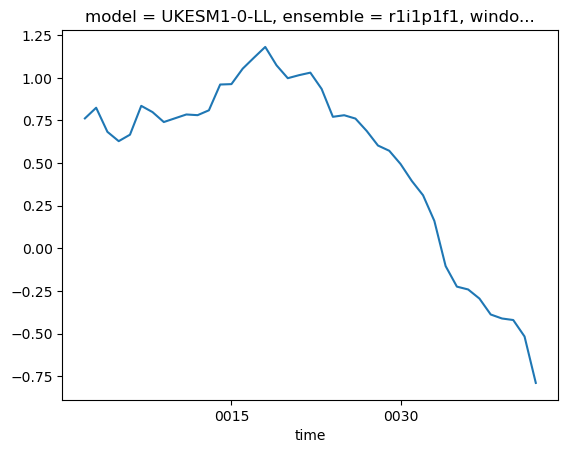

In [43]:
(signal_a1_ds/noise_a1_ds).plot()

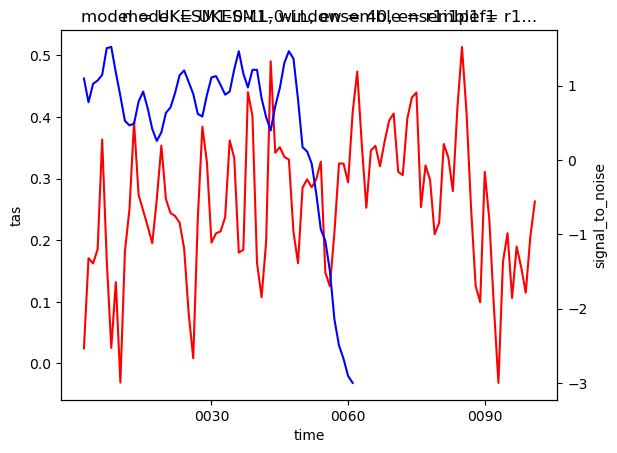

In [44]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
a1_smean_anom_ds.sel(model='UKESM1-0-LL').plot(ax=ax, color='red')
sn_multi_rolling_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).plot(ax=ax2, color='blue')

In [45]:
def calculate_manual_rolling_signal(arr, window):
    x = np.arange(window)
    gradients = []
    for i in range(len(arr)-window):
        arr_i_select = arr[i:i+window]
        grad, _ = np.polyfit(x, arr_i_select, deg=1)
        gradients.append(grad)
    signal = np.array(gradients) * window
    return signal

In [46]:
window=40

In [47]:
arr = a1_smean_anom_ds.sel(model='UKESM1-0-LL').values

In [48]:
manual_signal = calculate_manual_rolling_signal(arr, window)

In [49]:
trend_fit_test = stats.polynomial_fit(arr, order=3)

In [50]:
detrend_test = arr - trend_fit_test

In [51]:
std_list = []
for i in range(len(trend_fit_test)-window):
    sub_std = np.std(detrend_test[i:i+window])
    std_list.append(sub_std)
std_list = np.array(std_list)

In [52]:
sn_ratio_mannual = manual_signal/std_list

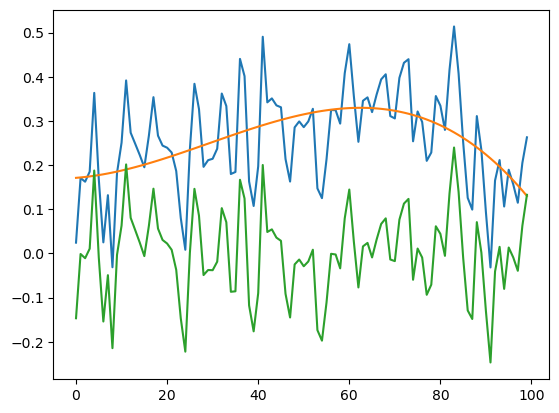

In [53]:
plt.plot(a1_smean_anom_ds.sel(model='UKESM1-0-LL').values)
plt.plot(trend_fit_test)
plt.plot(detrend_test)

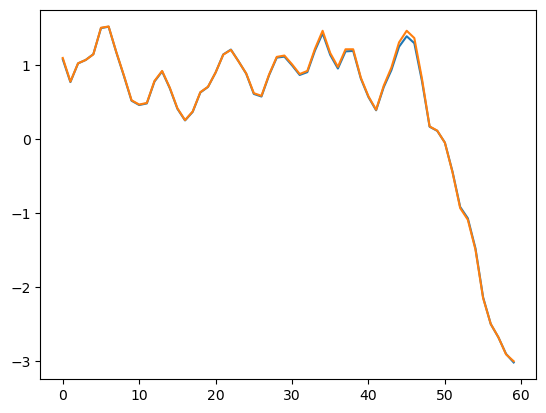

In [54]:
plt.plot(sn_ratio_mannual)
plt.plot(sn_multi_rolling_ds.signal_to_noise.sel(model='UKESM1-0-LL', window=40).values)


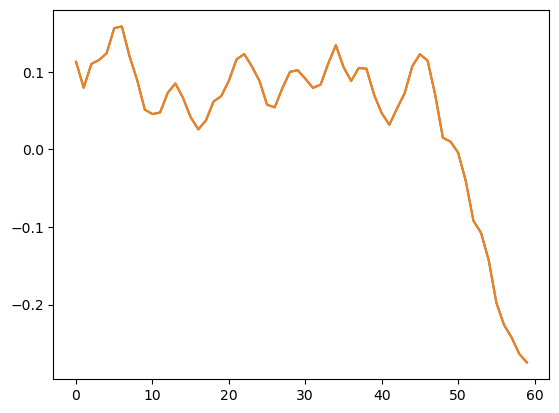

In [55]:
plt.plot(sn_multi_rolling_ds.signal.sel(model='UKESM1-0-LL', window=40).values)
plt.plot(manual_signal)

# testing signal definitions

In [56]:
window=40

In [57]:
period=20+30

In [58]:
start_year = a1_raw_xrlist['UKESM1-0-LL'].time.dt.year.values[0]
start_year

1916

In [59]:
pct_smean_xrlist['UKESM1-0-LL'].time.values[:5]

array([cftime.Datetime360Day(1850, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1851, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1852, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1853, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1854, 12, 30, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [60]:
pct_at_branch = pct_smean_xrlist['UKESM1-0-LL'].where(
    pct_smean_xrlist['UKESM1-0-LL'].time.dt.year.isin(np.arange(start_year-10, start_year)), 
    drop=True).squeeze().compute()

In [61]:
a1_arr = a1_smean_xrlist['UKESM1-0-LL'].squeeze().values

In [62]:
merged_data = np.concatenate([pct_at_branch, a1_arr])
merged_data

array([15.39442634, 15.55937773, 15.56281518, 15.47634399, 15.47852617,
       15.54902759, 15.56877835, 15.5820886 , 15.78448018, 15.80769596,
       15.91258137, 16.0589523 , 16.0505091 , 16.07327411, 16.25160191,
       16.05631464, 15.91322283, 16.02002134, 15.85686623, 16.07029518,
       16.13887059, 16.27980812, 16.16146323, 16.13624435, 16.11077026,
       16.08321253, 16.15490186, 16.24190705, 16.15477098, 16.13228293,
       16.12750179, 16.11659663, 16.07474451, 15.96841156, 15.89648368,
       16.12413169, 16.27217467, 16.21488797, 16.08419703, 16.09926461,
       16.10244304, 16.12532755, 16.25015842, 16.22180004, 16.06795905,
       16.07257667, 16.32851992, 16.289521  , 16.05099584, 15.99561642,
       16.08535805, 16.37869281, 16.23016452, 16.23914448, 16.22338297,
       16.21897002, 16.10175706, 16.050901  , 16.17350683, 16.18699209,
       16.1740275 , 16.1869872 , 16.21560896, 16.03545256, 16.01328991,
       16.10132116, 16.21279632, 16.21242022, 16.18203922, 16.29

In [63]:
import cftime

In [64]:
t0 = cftime.datetime(1, 1, 1, 0, 0, 0, 0, calendar='gregorian')

In [65]:
time = xr.cftime_range(start=t0, periods=len(merged_data), freq='Y')

In [66]:
new_dax = xr.DataArray(merged_data, coords={'time':time}, dims='time')
new_dax

<xarray.DataArray (time: 110)>
array([15.39442634, 15.55937773, 15.56281518, 15.47634399, 15.47852617,
       15.54902759, 15.56877835, 15.5820886 , 15.78448018, 15.80769596,
       15.91258137, 16.0589523 , 16.0505091 , 16.07327411, 16.25160191,
       16.05631464, 15.91322283, 16.02002134, 15.85686623, 16.07029518,
       16.13887059, 16.27980812, 16.16146323, 16.13624435, 16.11077026,
       16.08321253, 16.15490186, 16.24190705, 16.15477098, 16.13228293,
       16.12750179, 16.11659663, 16.07474451, 15.96841156, 15.89648368,
       16.12413169, 16.27217467, 16.21488797, 16.08419703, 16.09926461,
       16.10244304, 16.12532755, 16.25015842, 16.22180004, 16.06795905,
       16.07257667, 16.32851992, 16.289521  , 16.05099584, 15.99561642,
       16.08535805, 16.37869281, 16.23016452, 16.23914448, 16.22338297,
       16.21897002, 16.10175706, 16.050901  , 16.17350683, 16.18699209,
       16.1740275 , 16.1869872 , 16.21560896, 16.03545256, 16.01328991,
       16.10132116, 16.21279632, 16.21242022, 16.18203922, 16.29619797,
       16.36185362, 16.24421358, 16.14084849, 16.23377712, 16.24144067,
       16.20807063, 16.24793034, 16.28229504, 16.2937399 , 16.19917694,
       16.19374694, 16.28560225, 16.31974496, 16.32787716, 16.14200424,
       16.20952962, 16.18580038, 16.09775361, 16.11660495, 16.24444277,
       16.22255903, 16.16784113, 16.30344665, 16.4019506 , 16.29507033,
       16.14008168, 16.01388915, 15.98735734, 16.19908741, 16.12214062,
       15.98097713, 15.85640736, 16.05320327, 16.0994853 , 15.99439695,
       16.07762567, 16.04435819, 16.00287333, 16.09311846, 16.15100164])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0110-12-31 00:00:00

In [67]:
new_dax = new_dax.expand_dims(model=['fill_values'])

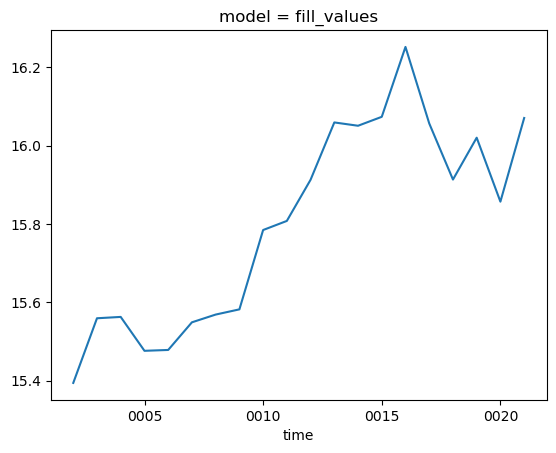

In [68]:
new_dax.isel(time=slice(None, 20)).plot()

In [69]:
new_dax.sn.rolling_signal?

Signature:
new_dax.sn.rolling_signal(
    window: int = 20,
    min_periods: int = 0,
    center=True,
    method: str = 'gradient',
    logginglevel='ERROR',
) -> xarray.core.dataarray.DataArray
Docstring: Previosuly signal_grad
File:      ~/Documents/PhD/modules/xarray_class_accessors.py
Type:      method

In [70]:
signal_grad_da = new_dax.isel(time=slice(20, None)).sn.rolling_signal(window=period)

In [71]:
signal_grad_pi_da = esmpi_smean_ds.sel(model='UKESM1-0-LL').sn.rolling_signal(window=period)

In [72]:
signal_period_diff_da = sn.calculate_rolling_period_diff(new_dax.isel(time=slice(20, None)), period)

In [73]:
signal_period_diff_pi_da = sn.calculate_rolling_period_diff(esmpi_smean_ds.sel(model='UKESM1-0-LL'), period)

(array([1.59975953, 0.79987976, 3.19951905, 1.59975953, 0.        ,
        0.79987976, 3.19951905, 6.39903811, 8.7986774 , 5.59915835]),
 array([-0.15549021, -0.12423551, -0.09298082, -0.06172612, -0.03047142,
         0.00078327,  0.03203797,  0.06329267,  0.09454737,  0.12580206,
         0.15705676]),
 <BarContainer object of 10 artists>)

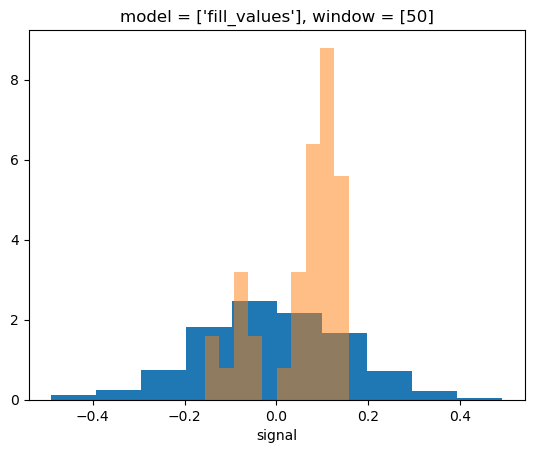

In [74]:
signal_grad_pi_da.plot.hist(density=True)
signal_grad_da.plot.hist(density=True, alpha=0.5)

(array([1.59975953, 0.79987976, 3.19951905, 1.59975953, 0.        ,
        0.79987976, 3.19951905, 6.39903811, 8.7986774 , 5.59915835]),
 array([-0.15549021, -0.12423551, -0.09298082, -0.06172612, -0.03047142,
         0.00078327,  0.03203797,  0.06329267,  0.09454737,  0.12580206,
         0.15705676]),
 <BarContainer object of 10 artists>)

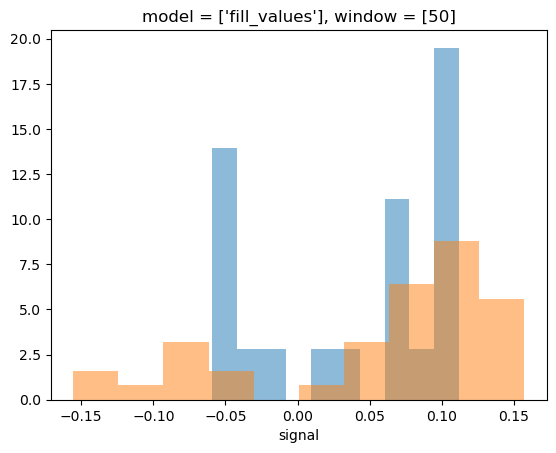

In [75]:
signal_period_diff_da.plot.hist(density=True, alpha=0.5)
signal_grad_da.plot.hist(density=True, alpha=0.5)

(array([13.92798886,  2.78559777,  2.78559777,  0.        ,  2.78559777,
         2.78559777,  0.        , 11.14239109,  2.78559777, 19.49918441]),
 array([-0.05934583, -0.04225109, -0.02515636, -0.00806163,  0.0090331 ,
         0.02612783,  0.04322257,  0.0603173 ,  0.07741203,  0.09450676,
         0.11160149]),
 <BarContainer object of 10 artists>)

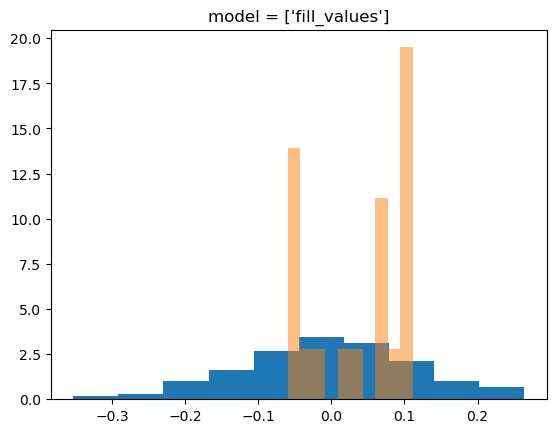

In [76]:
signal_period_diff_pi_da.plot.hist(density=True)
signal_period_diff_da.plot.hist(density=True, alpha=0.5)

(array([5., 1., 1., 0., 1., 1., 0., 4., 1., 7.]),
 array([-0.05934583, -0.04225109, -0.02515636, -0.00806163,  0.0090331 ,
         0.02612783,  0.04322257,  0.0603173 ,  0.07741203,  0.09450676,
         0.11160149]),
 <BarContainer object of 10 artists>)

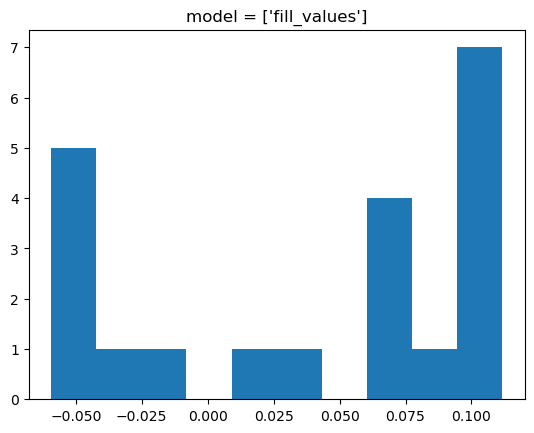

In [77]:
signal_period_diff_da.plot.hist()

# Hawkins Signal

In [78]:
da = a1_smean_anom_ds.sel(model='UKESM1-0-LL').isel(time=slice(0,60)).squeeze()

In [79]:
len_da = len(da)

In [80]:
x = np.arange(len_da)

In [81]:
grad_yint = np.polyfit(x=x, y=da.values,deg=1)

In [82]:
new_vals = np.poly1d(grad_yint)(x)

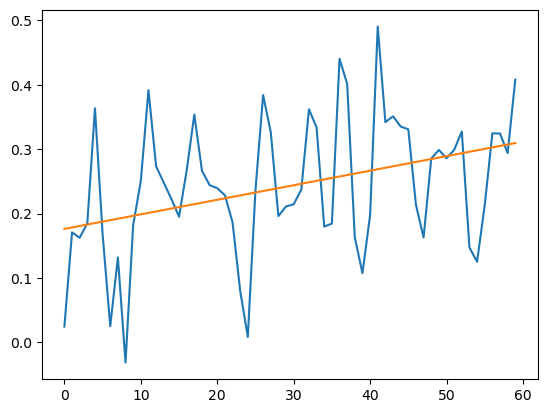

In [83]:
plt.plot(da)
plt.plot(new_vals)

In [84]:
noise = np.std(da-new_vals).values
noise

array(0.09967033)

In [85]:
(grad_yint[0] *  len(da))/noise

1.3604546729080245

In [86]:
lowess_fit = stats.trend_fit(da, method='lowess', lowess_window=41)

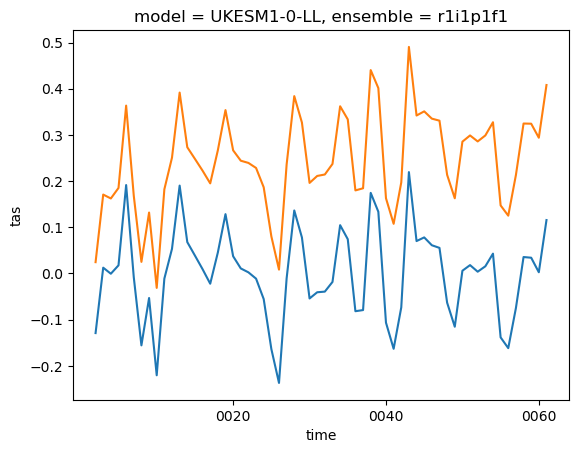

In [87]:
(da - lowess_fit).plot()
da.plot()

In [88]:
np.std((da - lowess_fit))

<xarray.DataArray 'tas' ()>
array(0.09887069)
Coordinates:
    model     <U14 'UKESM1-0-LL'
    ensemble  <U8 'r1i1p1f1'

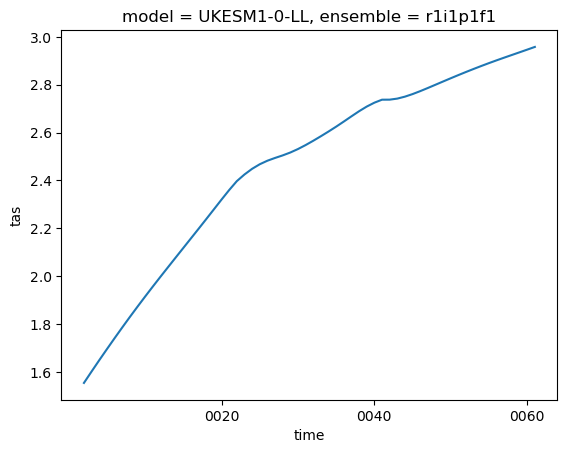

In [89]:
(lowess_fit/np.std((da - lowess_fit))).plot()

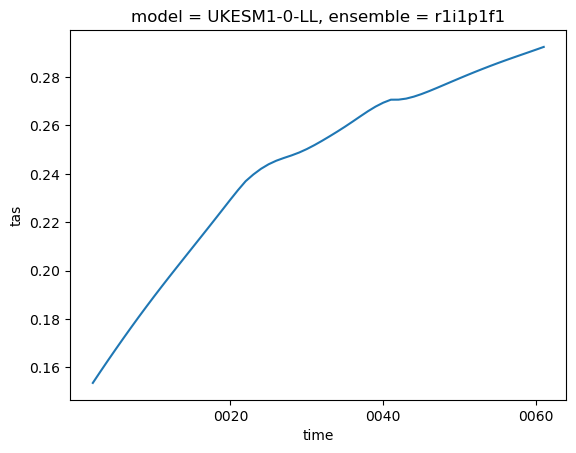

In [90]:
lowess_fit.plot()

In [91]:
from scipy import stats

def maximally_overlapping_t_test(data, window_size):
    results = []
    for i in range(len(data) - 2*window_size + 1):
        group1 = data[i:i+window_size]
        group2 = data[i+window_size:i+2*window_size]
        t_stat, p_value = stats.ttest_ind(group1, group2)
        results.append(p_value)
    return results

In [92]:
pvals = maximally_overlapping_t_test(da.values, 20)

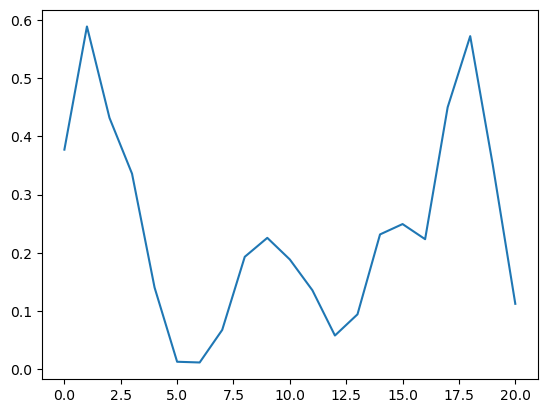

In [93]:
plt.plot(pvals)